![Rossmann](rossmann_mark.jpg)

Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

Rossmann is challenging you to predict 6 weeks of daily sales for 1,115 stores located across Germany. Reliable sales forecasts enable store managers to create effective staff schedules that increase productivity and motivation.    


## Metadata description
---
Columns       | Descriptions 
--------------|-------
Id|An Id that represents a (Store, Date) duple within the test set
Store|A unique Id for each store
Sales|The turnover on a given day (our target variable)
Customers|The number of customers on a given day
Open|open: 0 = the store is closed , 1 = the store is open
StateHoliday|Indicates a state holiday. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
SchoolHoliday|Store on this Date was affected or not by the closure of public schools
StoreType|4 different stores:a,b,c,d
Assortment|Assortment level: a = basic, b = extra, c = extended
CompetitionDistance|Distance in meters to the nearest competitor store
CompetitionOpenSince[Month/Year]|gives the approximate year and month of the time the nearest competitor was opened
Promo|Promo or not on that day
Promo2|Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
Promo2Since[Year/Week]|describes the year and calendar week when the store started participating in Promo2
PromoInterval|describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store


## What kind of problem to solve?

Regression or time series problem, here we propose regression method with embedding features tech to catch the data information

In [12]:
%reload_ext autoreload
%autoreload 2

import os, sys, numpy as np, pandas as pd, tensorflow as tf, re, codecs, json, time
import pickle, collections, random, math, numbers, scipy.sparse as sp, itertools, shutil
import requests, seaborn as sns

from datetime import datetime
from pprint import pprint
from matplotlib import pyplot as plt
# plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid') # 

ctx = os.path.abspath(os.path.dirname('.'))
if ctx not in sys.path:
    sys.path.insert(0, ctx)

from trainer import utils
from trainer import app_conf, metadata, input as inp, service
from trainer.ctrl import Ctrl

np.set_printoptions(precision=4, suppress=True, linewidth=100)
np.random.seed(42)

## Preview

In [16]:
tr = pd.read_csv('./data/train.csv')
store = pd.read_csv('./data/store.csv')
store_states = pd.read_csv('./data/store_states.csv')

d:\python\anaconda3\envs\py3_6\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [61]:
tr.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [62]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [63]:
store_states.head()

,Store,State
0,1,HE
1,2,TH
2,3,NW
3,4,BE
4,5,SN


## Data Exploration
- First we add some columns `year, month, day, promo2, sales_mean, customers_mean`
    - We treat `year, month, day` as categorical variables, we expect there are maybe some peak hour or off peak time on specific date, continuous variables couldn't handle this well.
    - `Promo2` is a continuing and consecutive promotion campaign, which have periodicity per year, it can calculate according to store.Promo2 and store.PromoInterval columns.
    - Both `sales_mean` and `customers_mean` columns are average of sales and customers per store, they can well catch the quantity respectively
  

In [19]:
tr_merge = tr.merge(store, how='left', on='Store').merge(store_states, how='left', on='Store')
tr_merge['StateHoliday'] = tr_merge.StateHoliday.map(str)
# tr_merge['PerCustomerSales'] = tr_merge.Sales / tr_merge.Customers

# Construct year, month, day columns, maybe on sepicific day or period will has some trends.
dt = pd.to_datetime(tr_merge.Date)
year, month, day = [], [], []
dt.map(lambda e: [year.append(e.year), month.append(e.month), day.append(e.day)]).head()
tr_merge['year'] = year
tr_merge['month'] = month
tr_merge['day'] = day
del year, month, day

# Promo2 is a continuing and consecutive promotion campaign, which have periodicity per year
# it can calculate according to store.Promo2 and store.PromoInterval columns
tr_merge['promo2'] = Ctrl.instance.input.cal_promo2(tr_merge)

# Construct customers mean and sales mean columns, at least we know whether this store is popular
tr_merge['sales_mean'] = tr_merge.groupby('Store').Sales.mean().reindex(tr_merge.Store).values
tr_merge['customers_mean'] = tr_merge.groupby('Store').Customers.mean().reindex(tr_merge.Store).values
tr_merge.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Promo2SinceWeek,Promo2SinceYear,PromoInterval,State,year,month,day,promo2,sales_mean,customers_mean
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,NaN,NaN,NaN,HE,2015,7,31,0,3945.704883,467.646497
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,13.0,2010.0,"Jan,Apr,Jul,Oct",TH,2015,7,31,1,4122.991507,486.045648
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,14.0,2011.0,"Jan,Apr,Jul,Oct",NW,2015,7,31,1,5741.253715,620.286624
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,NaN,NaN,NaN,BE,2015,7,31,0,8021.769639,1100.057325
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,NaN,NaN,NaN,SN,2015,7,31,0,3867.110403,444.360934


## Filter some rows
We found that on store close day of course sales equals to 0, so drop the `open = 0`

Promo
0    2771974337
1    3101206286
Name: Sales, dtype: int64


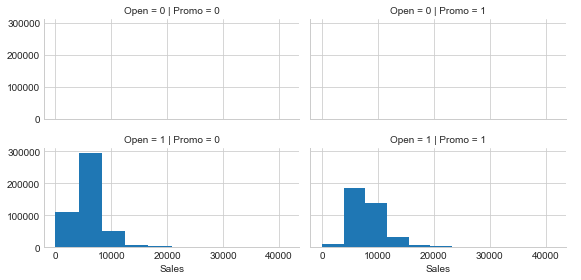

In [65]:
print(tr_merge.groupby('Promo').Sales.sum())
g = sns.FacetGrid(tr_merge, row='Open', col='Promo', size=2, aspect=2)
g = g.map(plt.hist, "Sales").add_legend()

In [66]:
# Remove Open != 1, because Sales = 0
tr_merge = tr_merge.query('Open == 1')

# a = tr_merge.groupby(['Store', 'Promo', 'StateHoliday', 'SchoolHoliday']).agg({
#     'Sales': sum, 'Customers': sum, 'Open': sum,
#     # 'StoreType': max, 'Assortment': max, 'State': max
# }).reset_index()
# a.head(20)

<br/>
<br/>
<br/>
<br/>
<br/>
<br/>

## Pearson Correlation
- Observe whether there are continuous columns have linear relation with target column `sales`
    - `Customers, sales_mean` have siginificant positive correlation

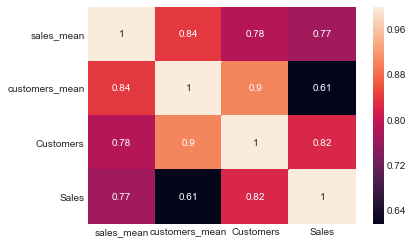

In [67]:
plt.figure(figsize=(6, 4))
sns.heatmap(tr_merge[['sales_mean', 'customers_mean', 'Customers', 'Sales']].corr(), annot=True)
plt.show()

<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
## Univariate Analysis
- Observe some categorical variables, see if there is some sigificant relation
- In this section:
    - Significant:
        - `Promo`: the sales raise in promo perieod.
        - `DayOfWeek`: When DayOfWeek = 7, it obviously people count less than average
        - `StoreType`: StoreType = 'b' has the lowest counts and the highest average
    - Not significant:
        - `Promo2`: Nothing found!

## Target Column: Sales
1. Observe the the describe table and boxplot of target, the mean is about 5773, so we need to take logrithm in order to reduce scale

count    1.017209e+06
mean     5.773819e+03
std      3.849926e+03
min      0.000000e+00
25%      3.727000e+03
50%      5.744000e+03
75%      7.856000e+03
max      4.155100e+04
Name: Sales, dtype: float64

count    1.017209e+06
mean     7.269391e+00
std      3.312016e+00
min      0.000000e+00
25%      8.223627e+00
50%      8.656085e+00
75%      8.969160e+00
max      1.063470e+01
Name: Sales, dtype: float64


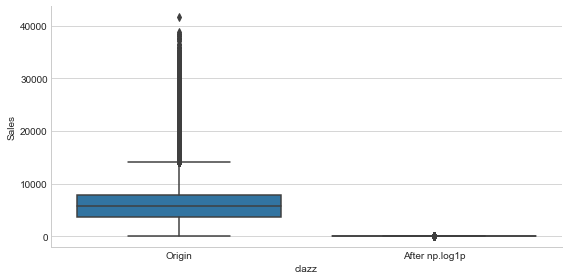

In [38]:
df = pd.DataFrame({'Sales': tr_merge.Sales.tolist() + np.log1p(tr_merge.Sales).tolist(), 
                   'clazz': ['Origin'] * len(tr_merge) + ['After np.log1p'] * len(tr_merge)})
print(df.query("clazz == 'Origin'").Sales.describe())
print()
print(df.query("clazz == 'After np.log1p'").Sales.describe())
sns.factorplot(x='clazz', y='Sales', data=df, kind="box", size=4, aspect=2, sharey=False)
plt.show()

## Promo

Promo
0    2771974337
1    3101206286
Name: Sales, dtype: int64


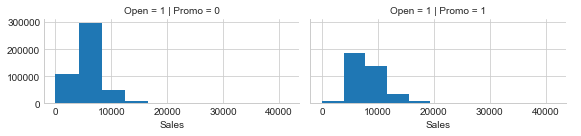

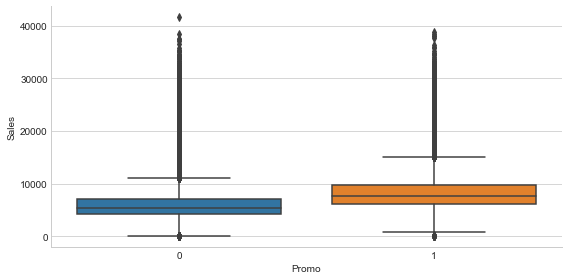

In [26]:
# plt.figure(figsize=(12, 6))
print(tr_merge.groupby('Promo').Sales.sum())
g = sns.FacetGrid(tr_merge, row='Open', col='Promo', size=2, aspect=2)
g = g.map(plt.hist, "Sales").add_legend()

sns.factorplot(x="Promo", y="Sales", data=tr_merge, kind="box", size=4, aspect=2)

In [27]:
agg = tr_merge.groupby(['Promo']).Sales.describe()
agg['sum'] = agg['count'] * agg['mean']
agg

,count,mean,std,min,25%,50%,75%,max,sum
Promo,,,,,,,,,
0,467496.0,5929.407603,2629.648385,0.0,4242.0,5459.0,7004.0,41551.0,2.771974e+09
1,376896.0,8228.281239,3175.759157,0.0,6069.0,7649.0,9686.0,38722.0,3.101206e+09


## Promo2

promo2
0    4930376023
1     942804600
Name: Sales, dtype: int64


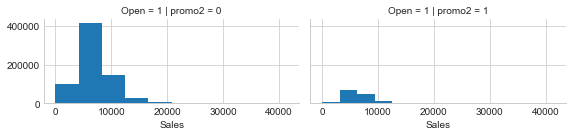

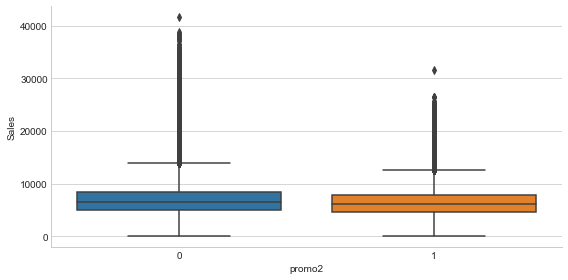

In [24]:
# plt.figure(figsize=(12, 6))
print(tr_merge.groupby('promo2').Sales.sum())
g = sns.FacetGrid(tr_merge, row='Open', col='promo2', size=2, aspect=2)
g = g.map(plt.hist, "Sales").add_legend()

sns.factorplot(x="promo2", y="Sales", data=tr_merge, kind="box", size=4, aspect=2)

In [25]:
agg = tr_merge.groupby(['promo2']).Sales.describe()
agg['sum'] = agg['count'] * agg['mean']
agg

,count,mean,std,min,25%,50%,75%,max,sum
promo2,,,,,,,,,
0,699164.0,7051.816202,3185.964977,0.0,4908.0,6440.0,8476.0,41551.0,4.930376e+09
1,145228.0,6491.892748,2626.976161,0.0,4650.0,6044.0,7837.0,31523.0,9.428046e+08


### DayOfWeek

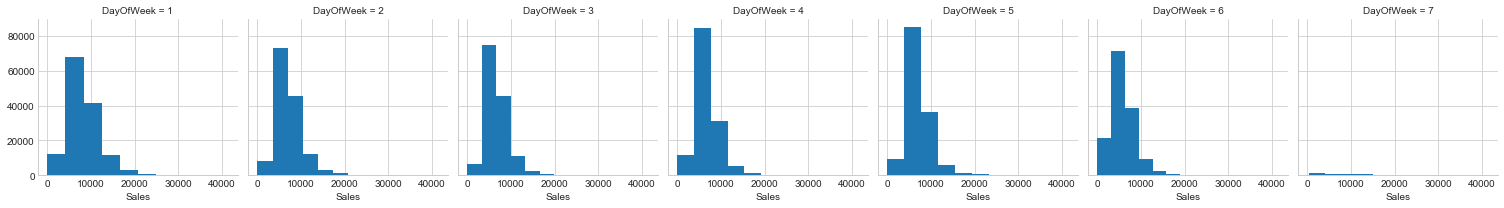

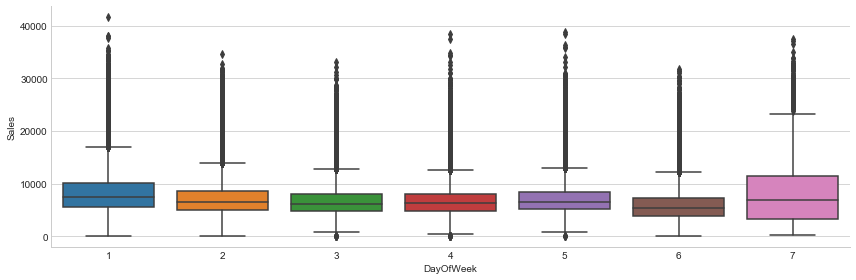

In [28]:
# plt.figure(figsize=(12, 6))
g = sns.FacetGrid(tr_merge, col='DayOfWeek', sharey=True, size=3, aspect=1)
g = g.map(plt.hist, "Sales")

sns.factorplot(x="DayOfWeek", y="Sales", data=tr_merge, kind="box", size=4, aspect=3)

In [29]:
agg = tr_merge.groupby('DayOfWeek').Sales.describe()
agg['sum'] = agg['count'] * agg['mean']
agg

,count,mean,std,min,25%,50%,75%,max,sum
DayOfWeek,,,,,,,,,
1,137560.0,8216.073074,3691.768876,0.0,5538.0,7539.0,10133.0,41551.0,1.130203e+09
2,143961.0,7088.113656,3066.237110,0.0,4960.0,6502.0,8521.0,34692.0,1.020412e+09
3,141936.0,6728.122978,2781.775174,0.0,4829.0,6210.0,7987.0,33151.0,9.549629e+08
4,134644.0,6767.310159,2764.548119,0.0,4900.0,6246.0,7987.0,38367.0,9.111777e+08
5,138640.0,7072.677012,2764.915744,0.0,5205.0,6580.0,8324.0,38722.0,9.805559e+08
6,144058.0,5874.840238,2852.730426,0.0,3925.0,5425.0,7232.0,31683.0,8.463177e+08
7,3593.0,8224.723908,6235.152960,286.0,3314.0,6876.0,11418.0,37376.0,2.955143e+07


## StoreType

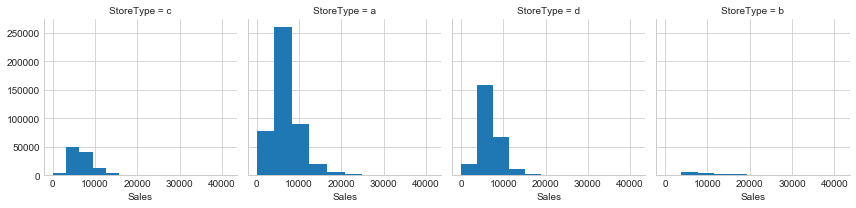

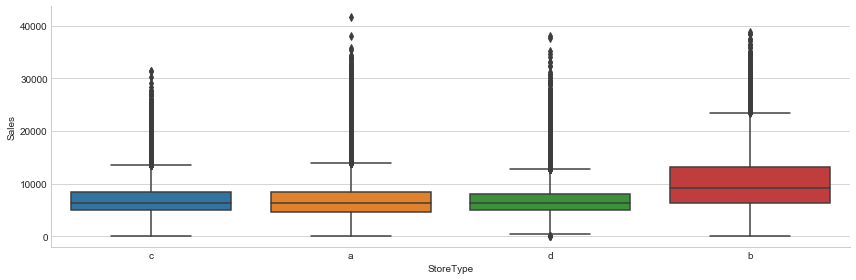

In [72]:
g = sns.FacetGrid(tr_merge, col='StoreType', sharey=True, size=3, aspect=1)
g = g.map(plt.hist, "Sales")

sns.factorplot(x="StoreType", y="Sales", data=tr_merge, kind="box", size=4, aspect=3)

In [73]:
agg = tr_merge.groupby('StoreType').Sales.describe()
agg['sum'] = agg['count'] * agg['mean']
agg

,count,mean,std,min,25%,50%,75%,max,sum
StoreType,,,,,,,,,
a,457077.0,6925.167661,3277.786381,0.0,4695.0,6285.0,8406.0,41551.0,3.165335e+09
b,15563.0,10231.407505,5157.190155,0.0,6344.0,9130.0,13183.5,38722.0,1.592314e+08
c,112978.0,6932.512755,2897.564578,0.0,4915.0,6407.0,8349.0,31448.0,7.832214e+08
d,258774.0,6822.141881,2556.582881,0.0,5050.0,6395.0,8123.0,38037.0,1.765393e+09


<br/>
<br/>
<br/>
<br/>
<br/>
## Bivariate Analysis
- In this section:
    - Significant:
        - `Promo + StateHoliday`: In mean heatmap figure, there is a peak on StateHoliday = 'b'
        - `State + StoreType`: When StoreType = 'b', the average of sales are unstable, and many States don't have StoreType 'b'
        
    - Not significant:
        - `Promo + SchoolHoliday`: Just found sum of the records with SchoolHoliday = 1 are less
        - `month + day`: In count heatmap, obviously records count(customers count) before july are upper than average, but we founds many store loss records in late date of timeline, that's why
        - `year + month`: Some peak in mean heatmap in December, corresponding to mean heatmap of [month + day], not really significant

In [68]:
def heatmap(*cols, annot=True):
    # cols = ['Promo', 'SchoolHoliday']
    pivot_params = list(cols) + ['Sales']
    g = tr_merge.groupby(cols).Sales
    mean_ = g.mean().reset_index().pivot(*pivot_params)
    count_ = g.size().reset_index().pivot(*pivot_params)
    sum_ = g.sum().reset_index().pivot(*pivot_params)

    f, axs = plt.subplots(1, 3, figsize=(16, 4))
    sns.heatmap(mean_, annot=annot, ax=axs[0])
    sns.heatmap(count_, annot=annot, ax=axs[1])
    sns.heatmap(sum_, annot=annot, ax=axs[2])
    axs[0].set_title(f'mean')
    axs[1].set_title(f'count')
    axs[2].set_title(f'sum')
    plt.show()

### Promo, SchoolHoliday 

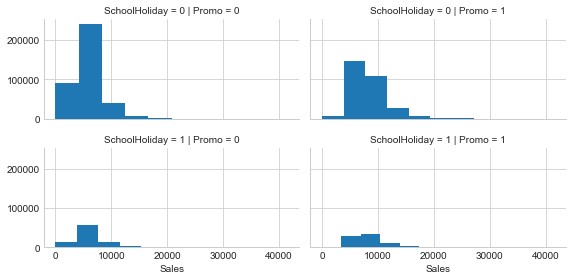

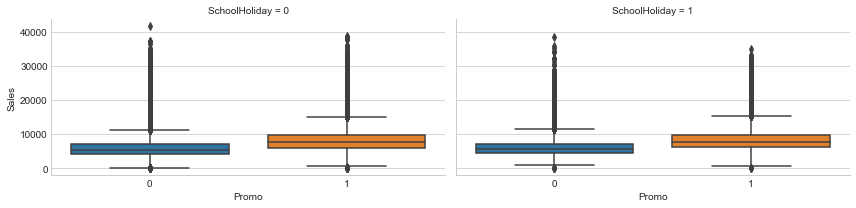

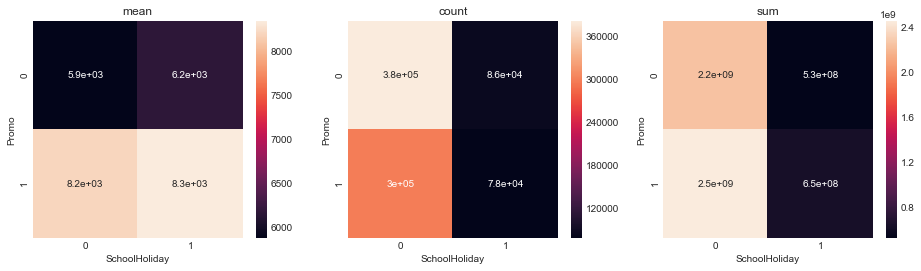

In [69]:
# print(tr_merge.groupby(['Store', 'SchoolHoliday', 'Promo']).Sales.sum())
g = sns.FacetGrid(tr_merge, row='SchoolHoliday', col='Promo', size=2, aspect=2)
g = g.map(plt.hist, "Sales").add_legend()

sns.factorplot(x="Promo", y="Sales", col='SchoolHoliday', data=tr_merge, kind="box", size=3, aspect=2)

heatmap('Promo', 'SchoolHoliday')

### Promo, StateHoliday 

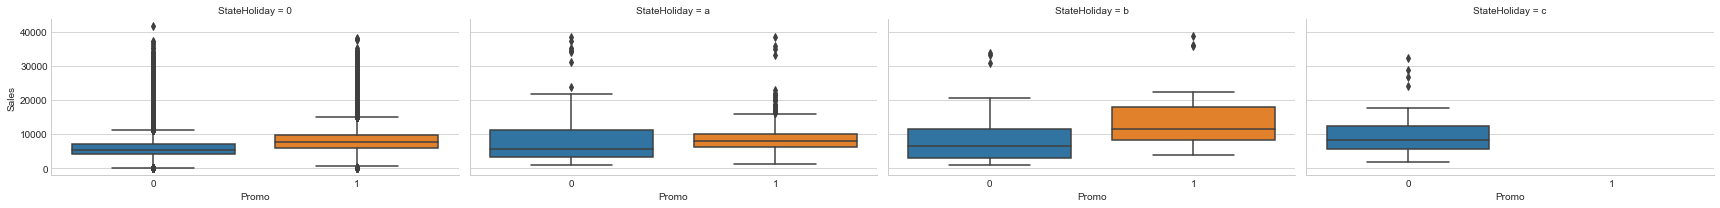

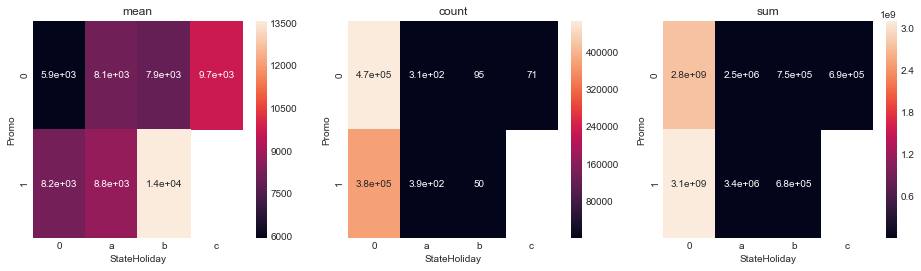

In [33]:
# g = sns.FacetGrid(tr_merge, row='StateHoliday', col='Promo', size=2, aspect=2)
# g = g.map(plt.hist, "Sales").add_legend()

sns.factorplot(x="Promo", y="Sales", col='StateHoliday', data=tr_merge, kind="box", size=3, aspect=2)

heatmap('Promo', 'StateHoliday')

### State, StoreType

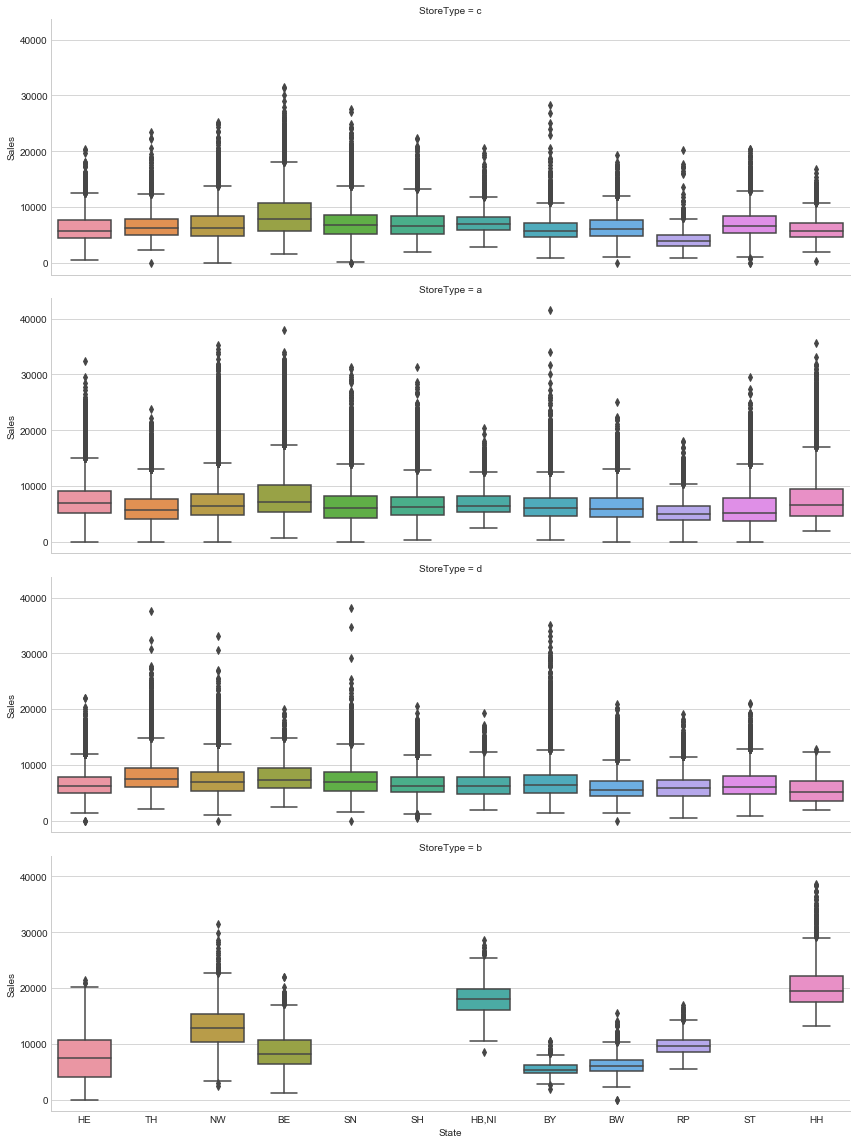

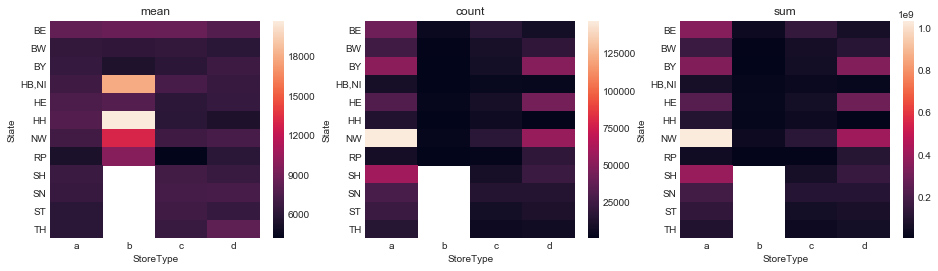

In [74]:
# g = sns.FacetGrid(tr_merge, col='State', row='StoreType', sharey=True, size=4, aspect=.5)
# g = g.map(plt.hist, "Sales")

sns.factorplot(x="State", y="Sales", row='StoreType', data=tr_merge, kind="box", size=4, aspect=3)

heatmap('State', 'StoreType', annot=False)

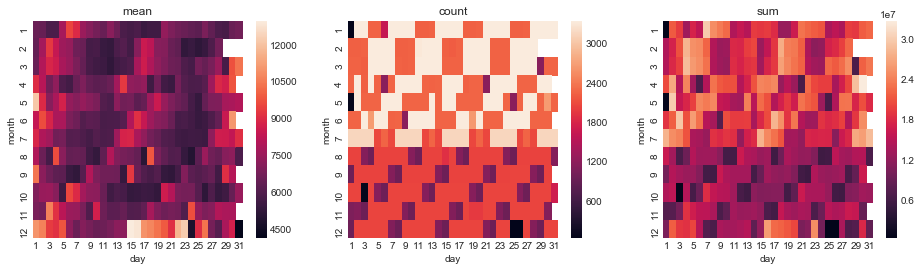

In [36]:
# sns.factorplot(x="day", y="Sales", row='month', data=tr_merge, kind="box", size=4, aspect=3)
heatmap('month', 'day', annot=False)

<br/>
<br/>
<br/>
## Recall The Exploration
There are many combination of columns we didn't see, to view all the combination is not efficient, that's why we use embedding to encode the categorical variables, in Tensorflow, `tf.feature_columns.crossed_column` can help us to make machine learn the information hidden in data, or handle all the combination by yourself, but imagine that we couldn't expect all the crossed combination happend in training data, if some outlier happened in serving time, the performance usually bad as expected.
<br/><br/>
Fortunately, without using crossed features we still got good performance, and we drop `year` columns as the same reason we mentioned, future year not show in training data result in the bad performance happended (Remember we treat year as categorical variable), month and day features  show periodically

## Module structure
    ```
    └─trainer
        │  app_conf.py
        │  ctrl.py
        │  input.py
        │  logging.yaml
        │  metadata.py
        │  model.py
        │  service.py
        └─ utils.py        
    ```
    Directory trainer contains all modules: 
    
|File Name| Purpose| Do You Need to Change?
|:---|:---|:---
|[app_conf.py](trainer/app_conf.py) | Applicaiton configures, tell where are the training data, the model checkpoint directory, and hyperparameter | **Yes**, any params you don't want to pass in ctrl.py, you can put them here, but still, like the path to train directory, it's suggested to put app_conf.py instead of pass on the fly to controller.
|[ctrl.py](trainer/ctrl.py) |The entrance of the program, accept any parameters, protable for local terminal or restful style environment. | **Maybe**, althought the processing is constructed, some of detail you might wont to modify.
|[service.py](trainer/service.py) |The business logic module behind the controller(ctrl.py) | **Yes**, usually you still have your own programe process
|[utils.py](trainer/service.py) | Utility module, some common function to put here, like logging function. | **Yes**, maybe you will have some special utils function to implement.
|[metadata.py](trainer/metadata.py)|Defines: 1) task type, 2) input data header, 3) numeric and categorical feature names, 4) target feature name (and labels, for a classification task), and 5) unused feature names. | **Yes**, as you will need to specify the metadata of your dataset. **This might be the only module to change!**
|[input.py](trainer/input.py)| Includes: 1) data input functions to read data from csv and tfrecords files, 2) parsing functions to convert csv and tf.example to tensors, 3) function to implement your features custom  processing and creation functionality, and 4) prediction functions (for serving the model) that accepts CSV, JSON, and tf.example instances. | **Maybe**, if you want to implement any custom pre-processing and feature creation during reading data.
|[model.py](trainer/model.py)|Includes: 1) function to create DNNRegressor, 2) function to implement for a custom estimator model_fn. 3) include **Feature class** to assign the feature spec, the feature spec usually bind for specific model, so we put them together. | **Yes**, in **Model.get_estimator** Usually, at least you want to modify the hidden_units params.

<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
## Data preprocessing
1. Data offered like this
    ```
    │  store.csv
    │  store_states.csv
    │  test.csv
    └─ train.csv
    ```
2. Data pipeline on training period we propose 4 steps: **prepare -> fit -> transform -> split**
    - Prepare: 
        - Join store and store_states to make the **Fat table**
        - Add features we mentioned in data exploration, drop also.
        - Filter some records not appropriate, like open = 0
        - Maybe persistent some files
    - Fit: 
        - Persistent the statistical information of numeric features
        - Persistent the unique count value of categorical features
    - Transform:
        - Normalization, logarithm ... etc.
        - Make all categorical variable to int, one hot encoding ... etc.
        - Take logarithm of the target column
    - Split:
        - Do split logic, in this case we order by date, and take 0.3 as valid data size, train data is first 0.7 part, and rest is valid data
        
3. Data pipeline on serving period just 2 steps: **prepare -> transform**
    - Prepare: As prepare step in training period, just some detail different, like not filter open = 0 here
    - Transform: Same as transform step in training period, usually delete the target column

In [ ]:
%%time
from trainer import app_conf, input, metadata
from trainer.ctrl import Ctrl

Ctrl.instance.prepare(app_conf.instance)

<br/>
<br/>
<br/>
## Model Structure

The model mainly use tf.esimator.DNNRegressor
- Loss function: mean squre error, default fixed by `tf.estimator.DNNRegressor` 
- DNN Structure: `81 -> 1000 -> 500 -> 1`, 81 is the dimension of concatenate all features, the last output dimension must set to 1 because of the prediction target is float.
- No dropout: check the train section, we use best checkpoint picker to avoid overfitting.
- ReLU activation function at each layer
<br/><br/>

## Train
- Training for 3 epochs, use `tf.estimator.DNNRegressor`
- Use `tf.train.GradientDescent` Optimizer with learning rate `0.0001`
- Batch size = 256
- Best exporter: we do evaluation on every train epoch end, the export condition is better than last evaluation(lower loss or higher accuracy),
we don't export the worse result.
- When validation time, we observe the `MAE(Mean Absolute Error)` and `RMSE(Root Mean Square Error)` error metrics

In [3]:
%%time
from trainer import app_conf, metadata, input as inp, service
from trainer.ctrl import Ctrl

ctrl = Ctrl.instance
ctrl.train(None)

2018-07-02 11:17:53,473 - trainer.service - INFO [line:25] - Deleted job_dir D:\Python\notebook\ml_specialized\rossmann/models/dnn_regressor to avoid re-use
2018-07-02 11:17:53,494 - trainer.service - INFO [line:39] - Model Directory: D:\Python\notebook\ml_specialized\rossmann/models/dnn_regressor
2018-07-02 11:17:53,496 - BestScoreExporter - INFO [line:77] - BestScoreExporter init
INFO:Feature stats were successfully loaded from local file...
INFO:tensorflow:Using config: {'_model_dir': 'D:\\Python\\notebook\\ml_specialized\\rossmann/models/dnn_regressor', '_tf_random_seed': 878787, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 3, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 500, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001AC0AD62940>, '_task_type': 'worker', '_task_id': 0, '_global_id

2018-07-02 11:18:55,910 - trainer.input - INFO [line:370] - Files encoding: csv
2018-07-02 11:18:55,910 - trainer.input - INFO [line:371] - Batch size: 256
2018-07-02 11:18:55,910 - trainer.input - INFO [line:372] - Epoch count: 1
2018-07-02 11:18:55,910 - trainer.input - INFO [line:373] - Thread count: 8
2018-07-02 11:18:55,910 - trainer.input - INFO [line:374] - Shuffle: False
2018-07-02 11:18:55,910 - trainer.input - INFO [line:375] - ================
2018-07-02 11:18:55,910 - trainer.input - INFO [line:376] - 
2018-07-02 11:18:55,933 - trainer.input - INFO [line:317] - is_serving: False
INFO:tensorflow:Calling model_fn.
2018-07-02 11:18:55,980 - tensorflow - INFO [line:116] - Calling model_fn.
INFO:tensorflow:Calling model_fn.
2018-07-02 11:18:55,980 - tensorflow - INFO [line:116] - Calling model_fn.
INFO:tensorflow:Done calling model_fn.
2018-07-02 11:18:56,970 - tensorflow - INFO [line:116] - Done calling model_fn.
INFO:tensorflow:Done calling model_fn.
2018-07-02 11:18:57,000 - 

2018-07-02 11:19:19,993 - tensorflow - WARNING [line:121] - Export includes no default signature!
INFO:tensorflow:Restoring parameters from D:\Python\notebook\ml_specialized\rossmann/models/dnn_regressor\model.ckpt-2311
2018-07-02 11:19:20,021 - tensorflow - INFO [line:116] - Restoring parameters from D:\Python\notebook\ml_specialized\rossmann/models/dnn_regressor\model.ckpt-2311
INFO:tensorflow:Assets added to graph.
2018-07-02 11:19:20,060 - tensorflow - INFO [line:116] - Assets added to graph.
INFO:tensorflow:No assets to write.
2018-07-02 11:19:20,060 - tensorflow - INFO [line:116] - No assets to write.
INFO:tensorflow:SavedModel written to: b"D:\\Python\\notebook\\ml_specialized\\rossmann/models/dnn_regressor\\export\\estimator\\temp-b'1530501559'\\saved_model.pb"
2018-07-02 11:19:20,254 - tensorflow - INFO [line:116] - SavedModel written to: b"D:\\Python\\notebook\\ml_specialized\\rossmann/models/dnn_regressor\\export\\estimator\\temp-b'1530501559'\\saved_model.pb"
2018-07-02 11:

INFO:tensorflow:Evaluation [686/989]
2018-07-02 11:20:35,464 - tensorflow - INFO [line:116] - Evaluation [686/989]
INFO:tensorflow:Evaluation [784/989]
2018-07-02 11:20:37,640 - tensorflow - INFO [line:116] - Evaluation [784/989]
INFO:tensorflow:Evaluation [882/989]
2018-07-02 11:20:39,789 - tensorflow - INFO [line:116] - Evaluation [882/989]
INFO:tensorflow:Evaluation [980/989]
2018-07-02 11:20:41,940 - tensorflow - INFO [line:116] - Evaluation [980/989]
INFO:tensorflow:Finished evaluation at 2018-07-02-03:20:42
2018-07-02 11:20:42,164 - tensorflow - INFO [line:116] - Finished evaluation at 2018-07-02-03:20:42
INFO:tensorflow:Saving dict for global step 4622: average_loss = 0.037229255, global_step = 4622, loss = 9.527147, mae = 0.14085722, rmse = 0.19294883
2018-07-02 11:20:42,164 - tensorflow - INFO [line:116] - Saving dict for global step 4622: average_loss = 0.037229255, global_step = 4622, loss = 9.527147, mae = 0.14085722, rmse = 0.19294883
2018-07-02 11:20:42,170 - BestScoreExp

2018-07-02 11:20:43,270 - trainer.input - INFO [line:374] - Shuffle: True
2018-07-02 11:20:43,270 - trainer.input - INFO [line:375] - ================
2018-07-02 11:20:43,270 - trainer.input - INFO [line:376] - 
2018-07-02 11:20:43,280 - trainer.input - INFO [line:317] - is_serving: False
INFO:tensorflow:Calling model_fn.
2018-07-02 11:20:43,339 - tensorflow - INFO [line:116] - Calling model_fn.
INFO:tensorflow:Calling model_fn.
2018-07-02 11:20:43,339 - tensorflow - INFO [line:116] - Calling model_fn.
INFO:tensorflow:Done calling model_fn.
2018-07-02 11:20:44,260 - tensorflow - INFO [line:116] - Done calling model_fn.
INFO:tensorflow:Done calling model_fn.
2018-07-02 11:20:44,264 - tensorflow - INFO [line:116] - Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
2018-07-02 11:20:44,264 - tensorflow - INFO [line:116] - Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
2018-07-02 11:20:44,339 - tensorflow - INFO [line:116] - Graph was finalized.
INFO:tenso

### Model Performance(TensorBoard Screen Shot): RMSE on Valid Data: 0.19
![Pic from tensrorboard](model_metric.jpg)

<br/>
<br/>
<br/>
<br/>
<br/>
<br/>

## Protocol buffer file inspection
- Use saved_model_cli to inspect the protocol buff schema

In [48]:
export_dir = utils.find_latest_expdir(app_conf.instance)
print( utils.cmd(f'saved_model_cli show --dir {export_dir}') )

d:\python\anaconda3\envs\py3_6\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
The given SavedModel contains the following tag-sets:
serve



In [49]:
export_dir = utils.find_latest_expdir(app_conf.instance)
print( utils.cmd(f'saved_model_cli show --dir {export_dir} --tag_set serve') )

d:\python\anaconda3\envs\py3_6\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
The given SavedModel MetaGraphDef contains SignatureDefs with the following keys:
SignatureDef key: "predict"



In [50]:
export_dir = utils.find_latest_expdir(app_conf.instance)
command = f'saved_model_cli show --dir {export_dir} --tag_set serve --signature_def predict'
print( utils.cmd(command) )

d:\python\anaconda3\envs\py3_6\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
The given SavedModel SignatureDef contains the following input(s):
  inputs['assortment'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: assortment:0
  inputs['day'] tensor_info:
      dtype: DT_INT32
      shape: (-1)
      name: day:0
  inputs['day_of_week'] tensor_info:
      dtype: DT_INT32
      shape: (-1)
      name: day_of_week:0
  inputs['month'] tensor_info:
      dtype: DT_INT32
      shape: (-1)
      name: month:0
  inputs['open'] tensor_info:
      dtype: DT_INT32
      shape: (-1)
      name: open:0
  inputs['promo'] tensor_info:
      dtype: DT_INT32
      shape: (-1)
      name: promo:0
  inputs['promo2'] tensor_info:
      dtype: DT_INT32
  

## Local prediction
1. Transform raw input data for prediction
2. Local prediction
    - call ctrl.local_predict: simply use `tensorflow.contrib.predictor`
        ```python
        from tensorflow.contrib import predictor
        predict_fn = predictor.from_saved_model(export_dir, signature_def_key='predict')
        pred = predict_fn( ... )
        ```
3. Online prediciton
    - deploy model to ml-engine
        1. Create model reository(resource)
        2. Add version in model container, in this example we clean the reository first (delete all old version)
        3. Determine the **default version**, default is the latest version
    - call ctrl.online_predict
    
4. In this case, we need to take np.expm1 to the predict result

In [38]:
%%time
from trainer import app_conf, metadata, input, service
from trainer.ctrl import Ctrl

ctrl = Ctrl.instance
test_df = ctrl.transform(pd.Series({'fpath': './data/test.csv'}))
params = pd.Series({
    'datasource': test_df,
    'is_src_file': False
})
pred = Ctrl.instance.local_predict(params)
print(pred)

INFO:tensorflow:Restoring parameters from b'D:\\Python\\notebook\\ml_specialized\\rossmann/models/dnn_regressor/export/estimator/1530166382\\variables\\variables'
2018-06-28 14:15:18,937 - tensorflow - INFO [line:116] - Restoring parameters from b'D:\\Python\\notebook\\ml_specialized\\rossmann/models/dnn_regressor/export/estimator/1530166382\\variables\\variables'
[ 6067.  9745. 11913. ...  5987. 26266.  6778.]
Wall time: 2.48 s


## Deply to ml-engine

- Set environ variable to read the api key json file: 
    - In trainer/app_conf.py, `Config.api_key_path` set the API key json path to acquire the access to any GCP service

In [3]:
%%time
from oauth2client.client import GoogleCredentials
from trainer import app_conf, metadata, input, service
from trainer.ctrl import Ctrl
ctrl = Ctrl.instance

ctrl.set_client_secret()

Wall time: 0 ns


- Upload saved pb file to GCS

In [4]:
%%time
ctrl = Ctrl.instance
p = pd.Series({
    'bucket_name': 'ml-specialized',
    'model_path': utils.find_latest_expdir(app_conf.instance),
    'prefix': 'models/rossmann'
})
ctrl.upload_model(p)

2018-07-02 11:30:31,405 - trainer.ctrl - INFO [line:66] - delete ml-specialized/models/rossmann/saved_model.pb
2018-07-02 11:30:31,481 - trainer.ctrl - INFO [line:66] - delete ml-specialized/models/rossmann/variables/variables.data-00000-of-00001
2018-07-02 11:30:31,556 - trainer.ctrl - INFO [line:66] - delete ml-specialized/models/rossmann/variables/variables.index
2018-07-02 11:30:31,622 - trainer.ctrl - INFO [line:70] - copy D:\Python\notebook\ml_specialized\rossmann\models\dnn_regressor\export\estimator\1530501642/saved_model.pb to models/rossmann/saved_model.pb
2018-07-02 11:30:32,968 - trainer.ctrl - INFO [line:70] - copy D:\Python\notebook\ml_specialized\rossmann\models\dnn_regressor\export\estimator\1530501642\variables/variables.data-00000-of-00001 to models/rossmann/variables/variables.data-00000-of-00001
2018-07-02 11:30:34,862 - trainer.ctrl - INFO [line:70] - copy D:\Python\notebook\ml_specialized\rossmann\models\dnn_regressor\export\estimator\1530501642\variables/variable

#### Deploy
- Create model resource and version
- Call deploy api

In [5]:
ctrl = Ctrl.instance
p = pd.Series({
    'model_name': 'ml_specilized_rossmann',
    'deployment_uri': 'gs://ml-specialized/models/rossmann'
})
ctrl.deploy(p)

2018-07-02 11:30:37,604 - googleapiclient.discovery - INFO [line:274] - URL being requested: GET https://www.googleapis.com/discovery/v1/apis/ml/v1/rest
2018-07-02 11:30:39,765 - googleapiclient.discovery - INFO [line:868] - URL being requested: POST https://ml.googleapis.com/v1/projects/ml-team-cloudmile/models?alt=json
2018-07-02 11:30:39,765 - oauth2client.transport - INFO [line:151] - Attempting refresh to obtain initial access_token
2018-07-02 11:30:39,768 - oauth2client.client - INFO [line:795] - Refreshing access_token
2018-07-02 11:30:41,348 - trainer.service - WARNING [line:114] - <HttpError 409 when requesting https://ml.googleapis.com/v1/projects/ml-team-cloudmile/models?alt=json returned "Field: model.name Error: A model with the same name already exists.">
2018-07-02 11:30:41,352 - googleapiclient.discovery - INFO [line:868] - URL being requested: GET https://ml.googleapis.com/v1/projects/ml-team-cloudmile/models/ml_specilized_rossmann/versions?alt=json
2018-07-02 11:30:41

- Call deployed model

Because of the traffic volume limitation, just show first 100 rows online prediction

In [55]:
test_df = Ctrl.instance.transform(pd.Series({'fpath': './data/test.csv'}))
p = pd.Series({
    'model_name': 'ml_specilized_rossmann',
    'datasource': test_df[:100].to_dict('records')
})
result = Ctrl.instance.online_predict(p)
result

2018-06-28 14:22:29,311 - googleapiclient.discovery - INFO [line:868] - URL being requested: POST https://ml.googleapis.com/v1/projects/ml-team-cloudmile/models/ml_specilized_rossmann:predict?alt=json
2018-06-28 14:22:29,313 - oauth2client.transport - INFO [line:151] - Attempting refresh to obtain initial access_token
2018-06-28 14:22:29,316 - oauth2client.client - INFO [line:795] - Refreshing access_token


array([ 6067.,  9745., 11913.,  7889.,  8293.,  7452., 10294.,  9888.,  6636.,  7696.,  8406.,
        9192.,  8226.,  9833.,  6712.,  6217.,  7268., 11901., 13569., 12362.,  9250.,  7581.,
        7284.,  5611., 10509., 12393., 12248.,  8046.,  6364.,  6424.,  6912., 12898.,  8382.,
        6989.,  6894.,  9083.,  5491.,  8897.,  5661.,  8352.,  9534.,  7040.,  9186.,  8583.,
        6138.,  8705.,  9041., 12404.,  7888.,  9667.,  9443., 11213.,  8557., 11640.,  5942.,
        6315.,  8335.,  7802., 11044.,  9943.,  7218.,  9788.,  9773., 11264.,  5190., 16683.,
        6351.,  8072., 10477.,  7306.,  7799.,  8238.,  8996.,  6259.,  6450., 10309.,  9309.,
        9573.,  5781.,  9918., 13744.,  8218.,  5858.,  8455.,  8262.,  9285.,  9043.,  5084.,
       10061.,  8038.,  8471.,  8580.,  5951.,  8369.,  7291.,  9068., 12310.,  6594.,  6764.,
        8054.])

<br/>
<br/>
<br/>
<br/>
<br/>
## Check predictions
---
Plot timeline in each store sales, prev 70% are training data and post 30% are validation data, predict valid data and compare to the ground truth

In [8]:
tr = pd.read_csv('./data/processed/train_pr.csv').query('open == 1')
vl = pd.read_csv('./data/processed/valid_pr.csv').query('open == 1')
# Add date column for time series inspection
tr['date'] = pd.read_json(app_conf.instance.tr_dt_file, typ='series').values
vl['date'] = pd.read_json(app_conf.instance.vl_dt_file, typ='series').values

tr['predict'] = np.nan
params = pd.Series({
    'datasource': vl.drop(['sales', 'date'], 1),
    'is_src_file': False
})
vl['predict'] = Ctrl.instance.local_predict(params)

merge = pd.concat([tr, vl], 0)
merge['sales'] = np.expm1(merge.sales)
merge.head()

d:\python\anaconda3\envs\py3_6\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


INFO:tensorflow:Restoring parameters from b'D:\\Python\\notebook\\ml_specialized\\rossmann/models/dnn_regressor/export/estimator/1530166382\\variables\\variables'
2018-07-02 10:06:58,215 - tensorflow - INFO [line:116] - Restoring parameters from b'D:\\Python\\notebook\\ml_specialized\\rossmann/models/dnn_regressor/export/estimator/1530166382\\variables\\variables'


,store,day_of_week,open,promo2,promo,state_holiday,school_holiday,store_type,assortment,state,month,day,sales_mean,sales,date,predict
0,1,3,1,0,0,0,1,c,a,HE,1,2,3945.704883,5530.0,2013-01-16,NaN
1,1,4,1,0,0,0,1,c,a,HE,1,3,3945.704883,4327.0,2013-01-16,NaN
2,1,5,1,0,0,0,1,c,a,HE,1,4,3945.704883,4486.0,2013-01-16,NaN
3,1,6,1,0,0,0,1,c,a,HE,1,5,3945.704883,4997.0,2013-01-16,NaN
4,1,1,1,0,1,0,1,c,a,HE,1,7,3945.704883,7176.0,2013-01-16,NaN


- Modify the pos variable to controll the start position, the following plot will show 3 figures a time

In [9]:
pos = 100

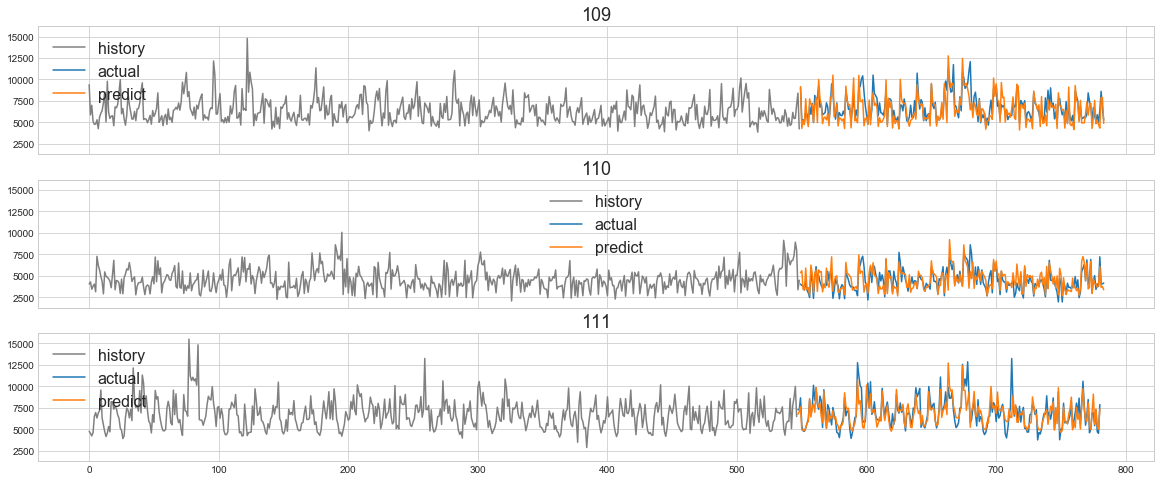

In [13]:
n_rows, n_cols = 3, 1
f, ax = plt.subplots(n_rows, n_cols, figsize=(20, 8), sharex=True, sharey=True)
for r, idx in enumerate(np.arange(pos, pos + n_rows)):
    samples = merge.query(f'store == {idx}').sort_values('date')
    hist = samples.query('predict.isnull()')
    predict = samples.query('predict.notnull()')
    ax[r].plot(np.arange(len(hist)), hist.sales.values, c='gray', label='history')
    ax[r].plot(np.arange(len(hist), len(hist) + len(predict)), predict.sales.values, label='actual')
    ax[r].plot(np.arange(len(hist), len(hist) + len(predict)), predict.predict.values, label='predict')
    ax[r].set_title(f'{idx}', size=18)
    ax[r].grid(True)
    ax[r].legend(loc='best', prop={'size': 16})
pos += n_rows
plt.show()

<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
## Appendix

+ Use `tf.saved_model.loader.load`, only for `json_serving_input_fn `

In [ ]:
%%time
from trainer import app_conf, metadata, input, service
from trainer.ctrl import Ctrl

ctrl = Ctrl.instance
test_df = ctrl.transform(pd.Series({'fpath': './data/test.csv'}))
params = pd.Series({
    'datasource': test_df,
    'is_src_file': False
})
pred = ctrl.local_predict_alt(params)
print(pred)

## Tensor data inspection

In [17]:
%%time
from trainer import app_conf, metadata, input, service
from trainer.ctrl import Ctrl

encoded, origin, feat_data, target_, all_ = Ctrl.instance.inspect('promo2')

2018-07-02 14:59:42,558 - trainer.input - INFO [line:365] - 
2018-07-02 14:59:42,560 - trainer.input - INFO [line:366] - * data input_fn:
2018-07-02 14:59:42,561 - trainer.input - INFO [line:367] - ================
2018-07-02 14:59:42,562 - trainer.input - INFO [line:368] - Mode: train
2018-07-02 14:59:42,563 - trainer.input - INFO [line:369] - Input file(s): D:\Python\notebook\ml_specialized\rossmann/data/processed/train_pr.csv
2018-07-02 14:59:42,564 - trainer.input - INFO [line:370] - Files encoding: csv
2018-07-02 14:59:42,565 - trainer.input - INFO [line:371] - Batch size: 5000
2018-07-02 14:59:42,566 - trainer.input - INFO [line:372] - Epoch count: 10
2018-07-02 14:59:42,567 - trainer.input - INFO [line:373] - Thread count: 8
2018-07-02 14:59:42,568 - trainer.input - INFO [line:374] - Shuffle: False
2018-07-02 14:59:42,568 - trainer.input - INFO [line:375] - ================
2018-07-02 14:59:42,569 - trainer.input - INFO [line:376] - 
2018-07-02 14:59:42,593 - trainer.input - INF

In [18]:
all_.shape

(5000, 81)

## Test

In [ ]:
%%time
from trainer import app_conf, metadata, input, service
from trainer.ctrl import Ctrl

ctrl = Ctrl.instance
serv_inp = ctrl.test()
pprint(serv_inp.receiver_tensors)
print()
pprint(serv_inp.features)